# Introduction

In [1]:
from ds_flow.io_flow import list_files_all_subdirectories

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from glob import glob
import IPython.display as ipd
import matplotlib.animation as animation
import matplotlib
from scipy.signal import find_peaks
from typing import Tuple, Union, Optional

# File Loading and Basic Analysis

In [2]:
filename = librosa.ex('trumpet')
y, sr = librosa.load(filename)

In [3]:
ipd.Audio(filename)

In [4]:
def plot_waveform(signal: np.ndarray, sample_rate: float) -> tuple:
    """
    Plots an audio waveform with time on the x-axis.

    Parameters
    ----------
    signal : np.ndarray
        The input audio signal
    sample_rate : float
        The sampling rate of the signal in Hz

    Returns
    -------
    tuple
        (fig, ax) - Matplotlib figure and axis objects for further customization

    Example
    -------
    >>> fig, ax = plot_waveform(y, sr)
    >>> plt.show()
    """
    # Create time array
    duration = len(signal) / sample_rate
    time = np.linspace(0, duration, len(signal))
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # Plot waveform
    ax.plot(time, signal, 'b-', linewidth=0.5)
    
    # Customize plot
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Audio Waveform')
    ax.grid(True)
    
    # Set y-axis limits with some padding
    max_amp = np.max(np.abs(signal))
    ax.set_ylim(-max_amp*1.1, max_amp*1.1)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

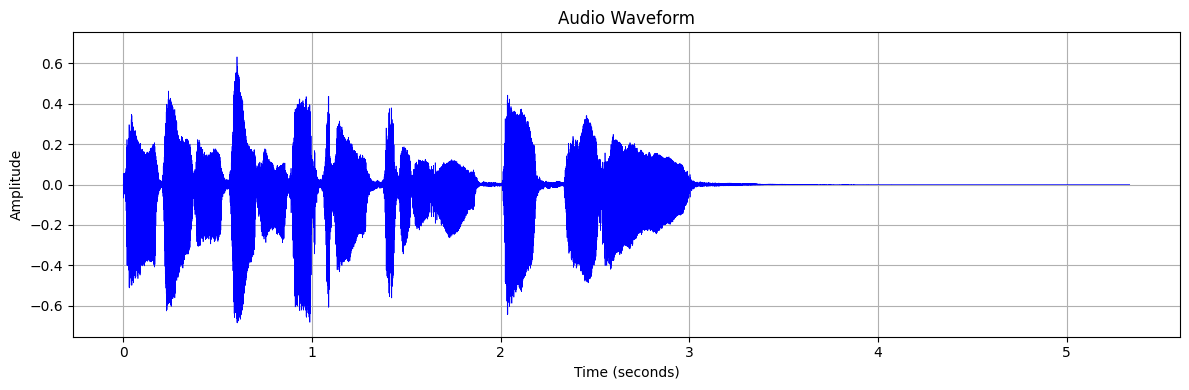

In [5]:
fig, ax = plot_waveform(y, sr)

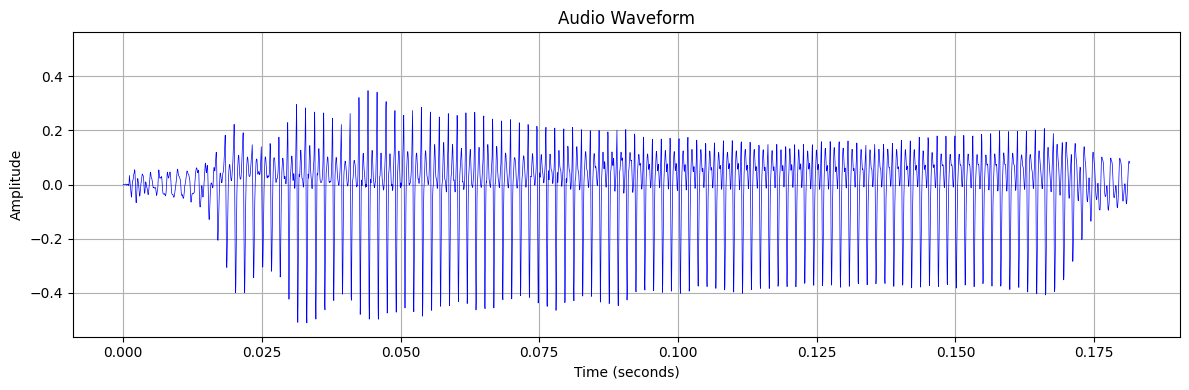

In [6]:
signal = y[0:4000]
fig, ax = plot_waveform(signal, sr)

In [7]:
ipd.Audio(data=signal, rate=sr)

# Frequency Decomposition and Harmonic Series analysis

In [8]:
def plot_frequency_spectrum(signal: np.ndarray, sample_rate: float, return_peaks: bool = False) -> tuple:
    """
    Analyzes and plots the frequency spectrum of an audio signal with peak detection
    and musical note labeling. Optionally returns the list of peak frequencies.

    Parameters
    ----------
    signal : np.ndarray
        The input audio signal
    sample_rate : float
        The sampling rate of the signal in Hz
    return_peaks : bool, optional
        If True, returns the list of peak frequencies along with the plot

    Returns
    -------
    tuple
        (fig, ax) - Matplotlib figure and axis objects for further customization
        If return_peaks is True, also returns a list of peak frequencies

    Example
    -------
    >>> fig, ax = plot_frequency_spectrum(y, sr)
    >>> plt.show()
    >>> fig, ax, peaks = plot_frequency_spectrum(y, sr, return_peaks=True)
    """
    # Compute FFT
    n = len(signal)
    fft_result = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(n, d=1/sample_rate)
    
    # Get positive frequencies
    positive_frequencies = frequencies[:n//2]
    magnitude_spectrum = np.abs(fft_result[:n//2])

    # Find peaks with hard-coded parameters
    peaks, _ = find_peaks(magnitude_spectrum, height= 2, distance=100)
    peaks_frequency = positive_frequencies[peaks]
    peaks_magnitude = magnitude_spectrum[peaks]

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot magnitude spectrum
    ax.plot(positive_frequencies, magnitude_spectrum, marker='.')
    
    # Plot peaks
    ax.plot(peaks_frequency, peaks_magnitude, 
            marker='x', color='red', linestyle='none')

    # Add note labels for each peak
    for freq, mag in zip(peaks_frequency, peaks_magnitude):
        note = librosa.hz_to_note(freq)
        ax.annotate(f'{note}={freq:.0f}Hz', 
                   xy=(freq, mag),  # Point to label
                   xytext=(freq-1000, mag+2),  # Text position
                   )

    max_idx = np.argmax(magnitude_spectrum)
    max_freq = positive_frequencies[max_idx]
    fundemental_note = librosa.hz_to_note(max_freq)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Magnitude")
    ax.set_title(f"Frequency Spectrum of trumpet note")
    ax.grid(True)

    # Adjust layout to prevent label clipping
    plt.tight_layout()

    if return_peaks:
        return fig, ax, peaks_frequency.tolist()
    else:
        return fig, ax

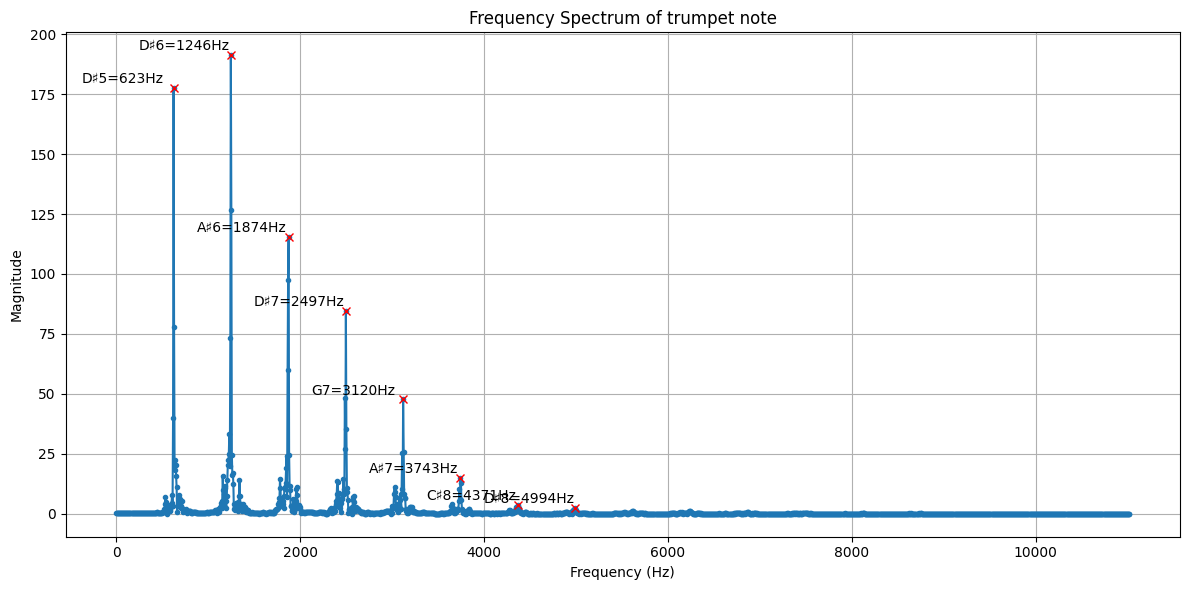

In [9]:
fig, ax, peak_frequencies = plot_frequency_spectrum(signal, sr, return_peaks=True)

# Define signal functions

In [10]:
def reconstruct_frequency(frequency: float, 
                        time: np.ndarray, 
                        amplitude: float, 
                        phase: float) -> np.ndarray:
    """
    Reconstructs a sinusoidal signal with specified frequency, amplitude, and phase.

    Parameters
    ----------
    frequency : float
        The frequency of the sinusoid in Hz.
    time : np.ndarray
        Time array in seconds.
    amplitude : float
        The amplitude of the sinusoid.
    phase : float
        The phase offset in radians.

    Returns
    -------
    np.ndarray
        The reconstructed sinusoidal signal.
    """
    return amplitude * np.cos(2 * np.pi * frequency * time + phase)

In [11]:
def get_frequency_amplitude(signal: np.ndarray, sample_rate: float, target_freq: float) -> float:
    """
    Finds the amplitude of a signal at a specific frequency.

    Parameters
    ----------
    signal : np.ndarray
        The input signal to analyze.
    sample_rate : float
        The sampling rate of the signal in Hz.
    target_freq : float
        The frequency to analyze in Hz.

    Returns
    -------
    float
        The amplitude of the signal at the target frequency.

    Raises
    ------
    ValueError
        If the target frequency is higher than the Nyquist frequency.
        If the signal is empty or the sample rate is invalid.
    """
    # Input validation
    if not isinstance(signal, np.ndarray):
        signal = np.array(signal)
    
    if len(signal) == 0:
        raise ValueError("Signal cannot be empty")
    
    if sample_rate <= 0:
        raise ValueError("Sample rate must be positive")
    
    nyquist = sample_rate / 2
    if target_freq >= nyquist:
        raise ValueError(f"Target frequency ({target_freq} Hz) must be less than "
                       f"Nyquist frequency ({nyquist} Hz)")

    # Compute FFT
    N = len(signal)
    Y = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, 1/sample_rate)

    # Find the index of the target frequency
    freq_idx = np.argmin(np.abs(freqs - target_freq))
    
    # Get amplitude at target frequency
    amplitude = 2.0/N * np.abs(Y[freq_idx])
    
    return amplitude

In [12]:
def get_frequency_phase(signal: np.ndarray, sample_rate: float, target_freq: float) -> float:
    """
    Finds the phase of a signal at a specific frequency.

    Parameters
    ----------
    signal : np.ndarray
        The input signal to analyze.
    sample_rate : float
        The sampling rate of the signal in Hz.
    target_freq : float
        The frequency to analyze in Hz.

    Returns
    -------
    float
        The phase of the signal at the target frequency in radians.

    Raises
    ------
    ValueError
        If the target frequency is higher than the Nyquist frequency.
        If the signal is empty or the sample rate is invalid.
    """
    # Input validation
    if not isinstance(signal, np.ndarray):
        signal = np.array(signal)
    
    if len(signal) == 0:
        raise ValueError("Signal cannot be empty")
    
    if sample_rate <= 0:
        raise ValueError("Sample rate must be positive")
    
    nyquist = sample_rate / 2
    if target_freq >= nyquist:
        raise ValueError(f"Target frequency ({target_freq} Hz) must be less than "
                       f"Nyquist frequency ({nyquist} Hz)")

    # Compute FFT
    N = len(signal)
    Y = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, 1/sample_rate)

    # Find the index of the target frequency
    freq_idx = np.argmin(np.abs(freqs - target_freq))
    
    # Get phase at target frequency
    phase = np.angle(Y[freq_idx])
    
    return phase

# Remove all frequencies except the fundamental

In [13]:
time_seconds = np.arange(len(signal)) / sr #define the time array in seconds for use later

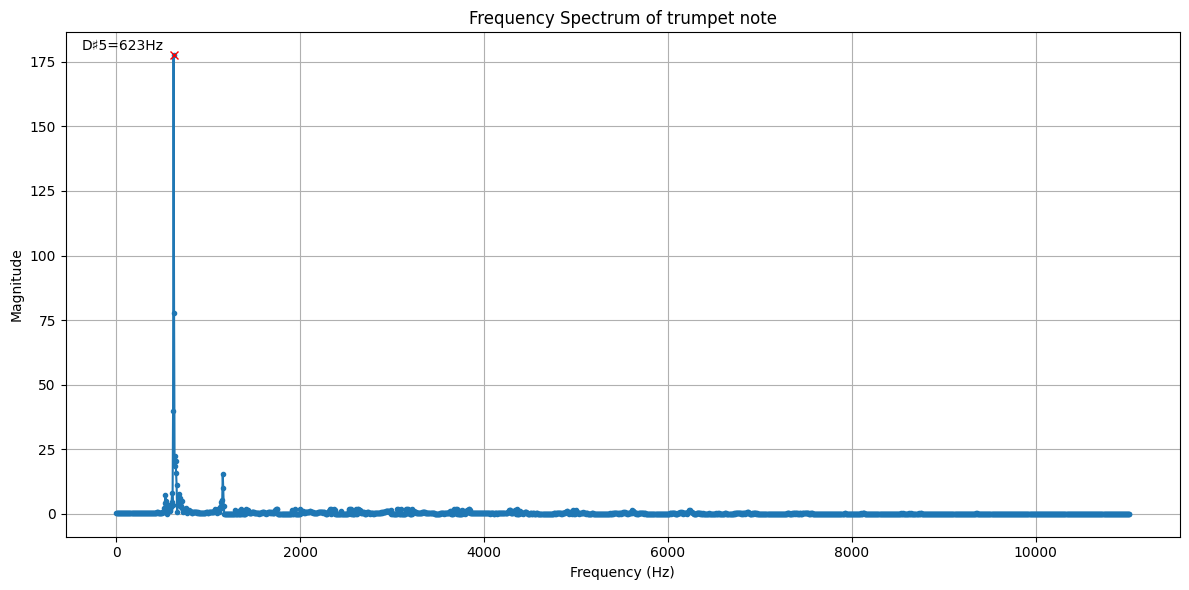

In [14]:
harmonics_removed = signal.copy()
while True:
    fig, ax, peak_frequencies = plot_frequency_spectrum(harmonics_removed, sr, return_peaks=True)
    if len(peak_frequencies) == 1:
        break
    plt.close(fig)  # Close the figure to prevent display
    for freq in peak_frequencies:
        if abs(freq - 622.9125) < 1:
            continue
        amplitude = get_frequency_amplitude(signal, sr, freq)
        phase = get_frequency_phase(signal, sr, freq)
        signal_freq = reconstruct_frequency(freq, time_seconds, amplitude, phase)
        harmonics_removed = harmonics_removed - signal_freq

In [15]:
ipd.Audio(data=harmonics_removed, rate=sr)

# Remove only fundamental

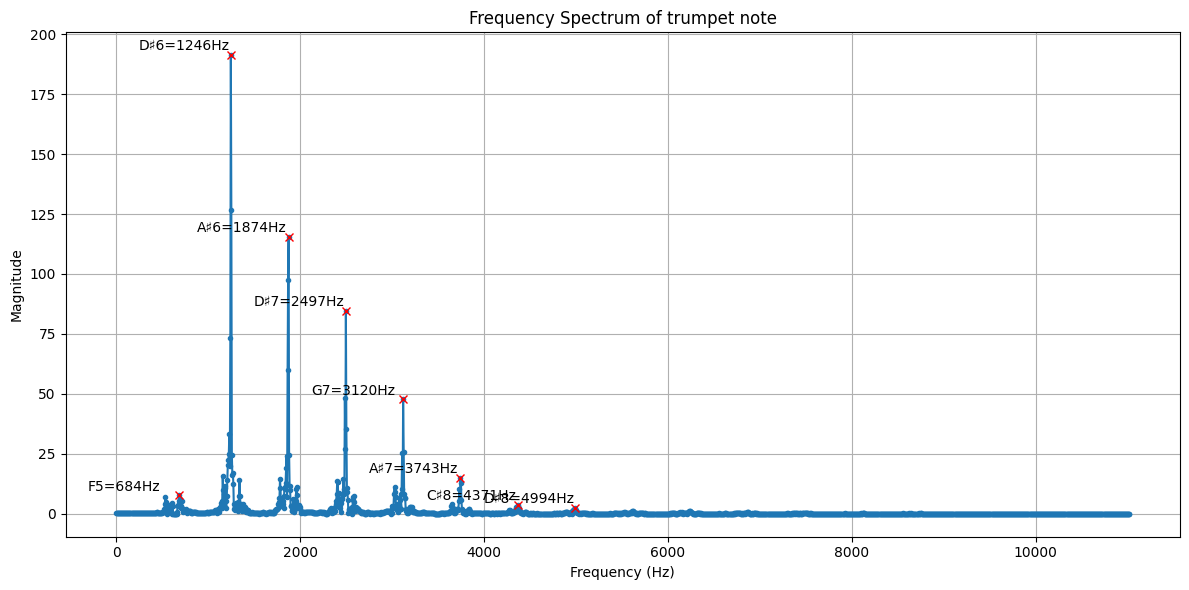

In [16]:
fundamental_removed = signal.copy()
last_peak_frequencies = []
while True:
    fig, ax, peak_frequencies = plot_frequency_spectrum(fundamental_removed, sr, return_peaks=True)
    if last_peak_frequencies == peak_frequencies:
        break
    last_peak_frequencies = peak_frequencies
    plt.close(fig)  # Close the figure to prevent display
    for freq in peak_frequencies:
        if abs(freq - 622.9125) > 50:
            continue
        amplitude = get_frequency_amplitude(signal, sr, freq)
        phase = get_frequency_phase(signal, sr, freq)
        signal_freq = reconstruct_frequency(freq, time_seconds, amplitude, phase)
        fundamental_removed = fundamental_removed - signal_freq

In [17]:
ipd.Audio(data=fundamental_removed, rate=sr)

# Remove all substantial frequencies

In [18]:
all_signals_removed = signal.copy()
removed_signals = []
removed_frequencies = []
removed_amplitudes = []
removed_phases = []
for freq in peak_frequencies:
    amplitude = get_frequency_amplitude(signal, sr, freq)
    phase = get_frequency_phase(signal, sr, freq)
    signal_freq = reconstruct_frequency(freq, time_seconds, amplitude, phase)
    removed_signals.append(signal_freq)
    removed_frequencies.append(freq)
    removed_amplitudes.append(amplitude)
    removed_phases.append(phase)
    all_signals_removed = all_signals_removed - signal_freq
    print(f"Removed frequency: {freq} Hz")

Removed frequency: 683.5500000000001 Hz
Removed frequency: 1245.825 Hz
Removed frequency: 1874.25 Hz
Removed frequency: 2497.1625 Hz
Removed frequency: 3120.0750000000003 Hz
Removed frequency: 3742.9875 Hz
Removed frequency: 4371.4125 Hz
Removed frequency: 4994.325 Hz


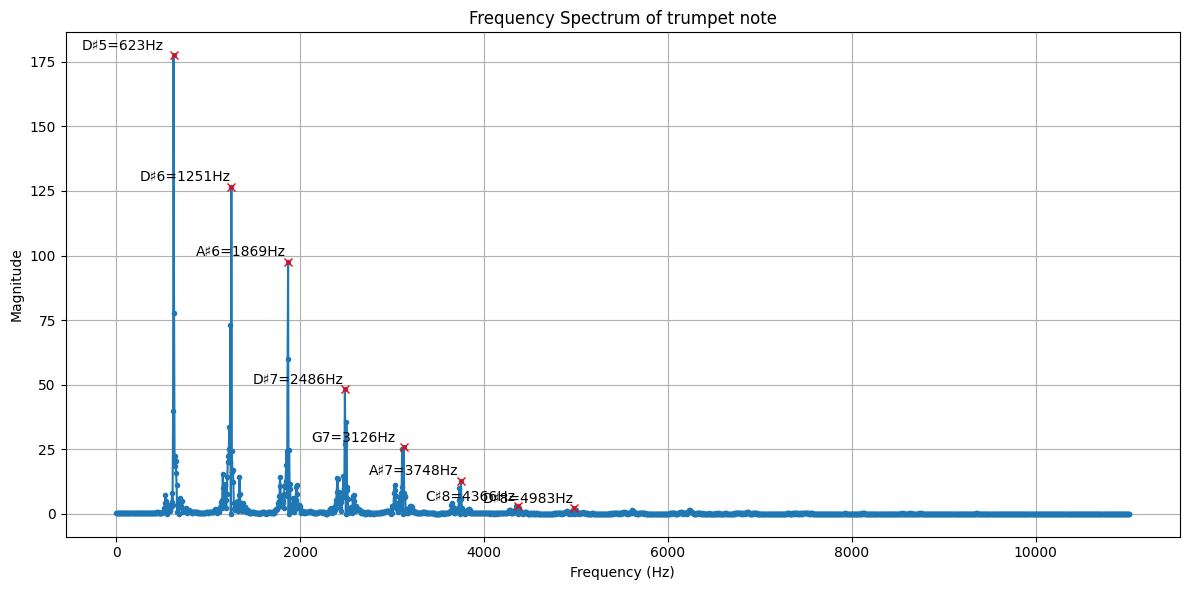

In [19]:
fig, ax, peak_frequencies = plot_frequency_spectrum(all_signals_removed, sr, return_peaks=True)

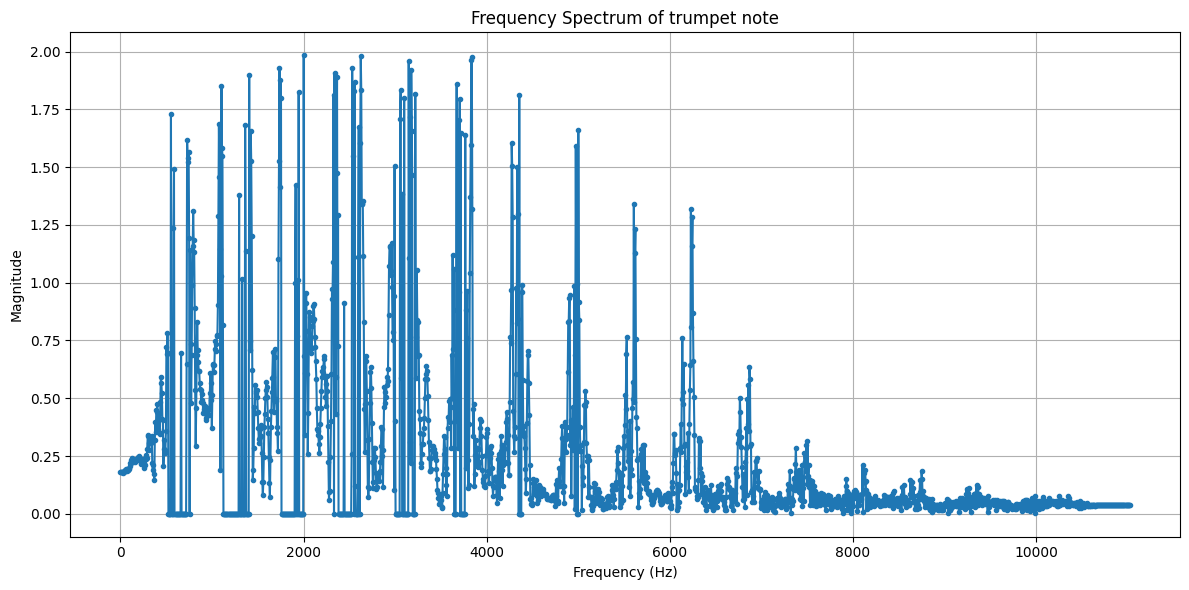

In [20]:
while True:
    fig, ax, peak_frequencies = plot_frequency_spectrum(all_signals_removed, sr, return_peaks=True)
    if len(peak_frequencies) == 0:
        break
    plt.close(fig)  # Close the figure to prevent display
    for freq in peak_frequencies:
        amplitude = get_frequency_amplitude(signal, sr, freq)
        phase = get_frequency_phase(signal, sr, freq)
        signal_freq = reconstruct_frequency(freq, time_seconds, amplitude, phase)
        removed_signals.append(signal_freq)
        removed_frequencies.append(freq)
        removed_amplitudes.append(amplitude)
        removed_phases.append(phase)
        all_signals_removed = all_signals_removed - signal_freq

In [21]:
ipd.Audio(data=all_signals_removed, rate=sr)

# Simulate the sound of a trumpet

In [22]:
removed_signals  = np.array(removed_signals)
summed_signals = np.sum(removed_signals, axis=0)
ipd.Audio(data=summed_signals, rate=sr)


In [23]:
#convert each list of np.float32 to python float
time_seconds = np.linspace(0, 1, 16000)
sr = 16000
removed_frequencies = [float(i) for i in removed_frequencies]
removed_amplitudes = [float(i) for i in removed_amplitudes]
removed_phases = [float(i) for i in removed_phases]
summed_signal = np.zeros(len(time_seconds))
for freq, amp, phase in zip(removed_frequencies, removed_amplitudes, removed_phases):
    reconstructed_signal = reconstruct_frequency(freq, time_seconds, amp, phase)
    summed_signal += reconstructed_signal
ipd.Audio(data=summed_signal, rate=sr)


In [24]:
# sort all the frequencies, amplitudes, and phases by frequency and keep the order the same for each list
sorted_freqs = sorted(removed_frequencies)
sorted_amplitudes = sorted(removed_amplitudes, key = lambda amp: removed_frequencies[removed_amplitudes.index(amp)])
sorted_phases = sorted(removed_phases, key = lambda phase: removed_frequencies[removed_phases.index(phase)])

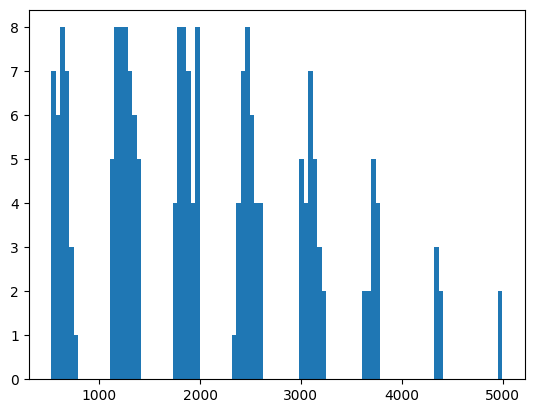

In [25]:
plt.hist(removed_frequencies, bins=100);

In [26]:
#group the frequencies, amplitudes, and phases by the fundamental frequencies they had originally
grouped_frequencies = []
grouped_amplitudes = []
grouped_phases = []
current_freq_group = [sorted_freqs[0]]
current_amp_group = [sorted_amplitudes[0]]
current_phase_group = [sorted_phases[0]]


for freq, amp, phase in zip(sorted_freqs[1:], sorted_amplitudes[1:], sorted_phases[1:]):
    if freq - current_freq_group[-1] < 200:#200 is an arbitrary distance threshold between each group of frequencies
        current_freq_group.append(freq)
        current_amp_group.append(amp)
        current_phase_group.append(phase)
    else:
        grouped_frequencies.append(current_freq_group)
        grouped_amplitudes.append(current_amp_group)
        grouped_phases.append(current_phase_group)
        current_freq_group = [freq]
        current_amp_group = [amp]
        current_phase_group = [phase]
grouped_frequencies.append(current_freq_group)
grouped_amplitudes.append(current_amp_group)
grouped_phases.append(current_phase_group)


In [27]:
for freq_group, amp_group, phase_group in zip(grouped_frequencies, grouped_amplitudes, grouped_phases):
    print(len(freq_group), len(amp_group), len(phase_group))



32 32 32
47 47 47
39 39 39
34 34 34
26 26 26
13 13 13
5 5 5
2 2 2


[629, 1255, 1870, 2478, 3098, 3710, 4364, 4988]
[np.float64(61.22558784747834), np.float64(80.89163721159916), np.float64(71.7927156727522), np.float64(72.17221120339951), np.float64(65.12960218239007), np.float64(41.29969176121058), np.float64(9.484063606914564), np.float64(5.512499999999818)]


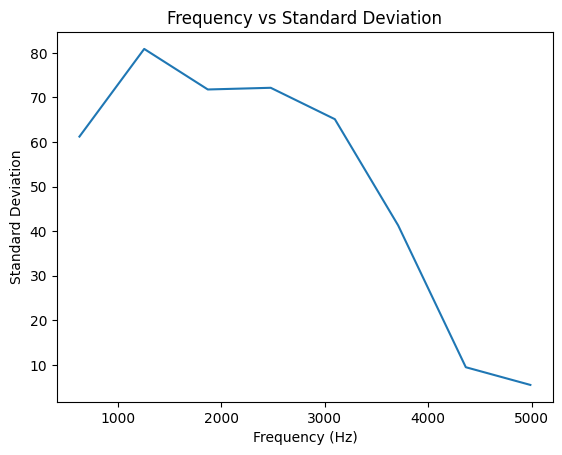

In [28]:
freq_means = []
freq_stdevs = []
freq_counts = []
for group in grouped_frequencies:
    freq_means.append(int(np.mean(group)))
    freq_stdevs.append(np.std(group))
    freq_counts.append(len(group))
print(freq_means), print(freq_stdevs)
plt.plot(freq_means,freq_stdevs)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Standard Deviation")
plt.title("Frequency vs Standard Deviation")
plt.show()

[np.float64(0.007513446744269459), np.float64(0.008215008687445933), np.float64(0.007083129785501231), np.float64(0.0057532119201770164), np.float64(0.004299256328242616), np.float64(0.0028359428621255434), np.float64(0.0014698929851874709), np.float64(0.0011645295307971537)]
[np.float64(0.016312470003126175), np.float64(0.01649735543952203), np.float64(0.01185993835254103), np.float64(0.007949510457974575), np.float64(0.004923313220234685), np.float64(0.0020682421349216395), np.float64(0.0002525589363544649), np.float64(9.450531797483563e-05)]


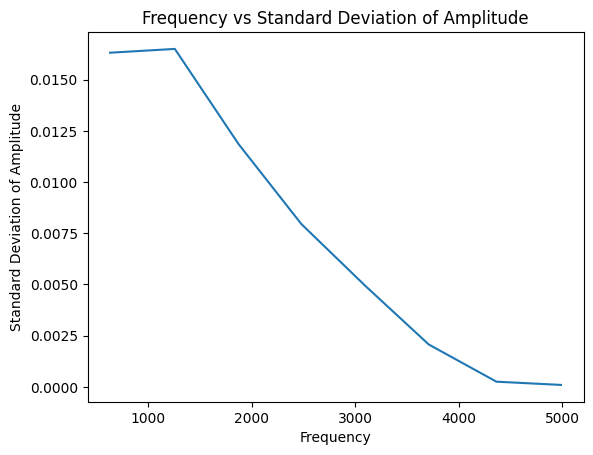

In [29]:
amplitude_means = []
amplitude_stdevs = []
amplitude_counts = []
for group in grouped_amplitudes:
    amplitude_means.append(np.mean(group))
    amplitude_stdevs.append(np.std(group))
    amplitude_counts.append(len(group))
print(amplitude_means), print(amplitude_stdevs)
plt.plot(freq_means,amplitude_stdevs)
plt.xlabel("Frequency")
plt.ylabel("Standard Deviation of Amplitude")
plt.title("Frequency vs Standard Deviation of Amplitude")
plt.show()



[np.float64(0.6334685474867001), np.float64(0.25461809622480513), np.float64(-0.013804770432985745), np.float64(0.3775499934768852), np.float64(0.13138868946295518), np.float64(0.1397051215171814), np.float64(0.8253543496131897), np.float64(1.2767290025949478)]
[np.float64(1.903573310106116), np.float64(1.8453549663759228), np.float64(1.6620355577180006), np.float64(1.7788448919364295), np.float64(1.8262146463941666), np.float64(1.6007758373781538), np.float64(1.4589503441545686), np.float64(1.6617420762777328)]


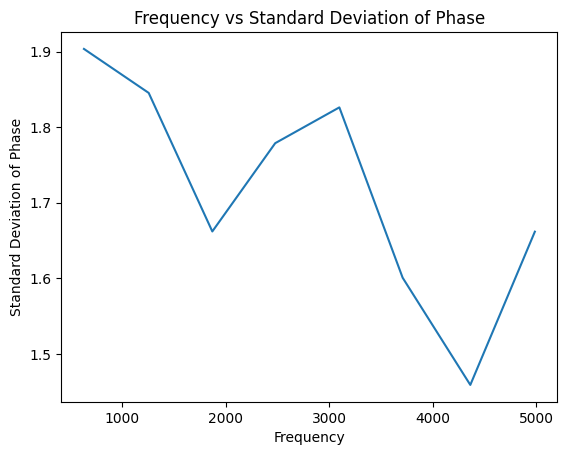

In [30]:
phase_means = []
phase_stdevs = []
phase_counts = []
for group in grouped_phases:
    phase_means.append(np.mean(group))
    phase_stdevs.append(np.std(group))
    phase_counts.append(len(group))
print(phase_means), print(phase_stdevs)
plt.plot(freq_means,phase_stdevs)
plt.xlabel("Frequency")
plt.ylabel("Standard Deviation of Phase")
plt.title("Frequency vs Standard Deviation of Phase")
plt.show()



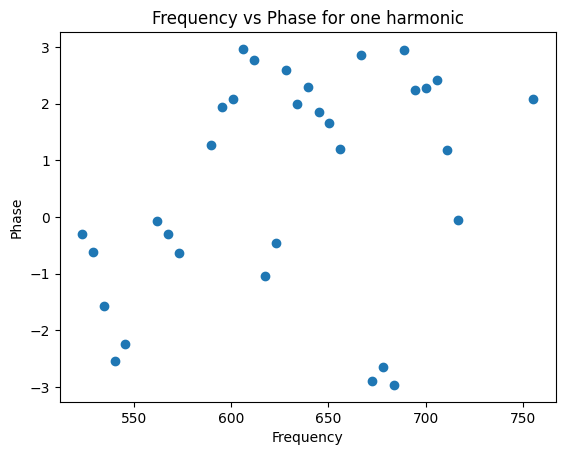

In [31]:
#phase seem fairly randomly distributed so I thin kwe can almost select at random what the phases is
group_freq_0, group_phase_0 = grouped_frequencies[0], grouped_phases[0]
len(group_freq_0), len(group_phase_0)
plt.scatter(group_freq_0, group_phase_0)
plt.xlabel("Frequency")
plt.ylabel("Phase")
plt.title("Frequency vs Phase for one harmonic")
plt.show()

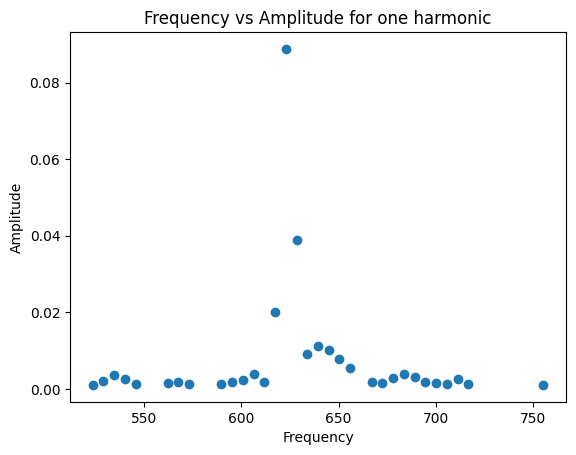

In [32]:
#observation: the amplitude is higher near the true frequency of the harmonic (as we can see in the FFT plots above)
group_freq_0, group_amp_0  = grouped_frequencies[0], grouped_amplitudes[0]
plt.scatter(group_freq_0, group_amp_0)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Frequency vs Amplitude for one harmonic")
plt.show()

In [33]:
factors_from_fundamental = []
for freq in freq_means:
    factors_from_fundamental.append(freq/freq_means[0])
print(factors_from_fundamental)

[1.0, 1.9952305246422894, 2.972972972972973, 3.9395866454689985, 4.925278219395866, 5.898251192368839, 6.9379968203497615, 7.930047694753577]


In [34]:
len(factors_from_fundamental), len(grouped_frequencies), len(grouped_amplitudes), len(grouped_phases)

(8, 8, 8, 8)

Given a note frequency (A-440hz) for example. We need to multiple 440 by all of these factors to get the prominent overtones. Thus we can make a function to give us the prominent overtones for any given pitch.

In [35]:
def get_harmonic_series(fundamental_freq_hz: float) -> np.ndarray:
    """
    Calculate the prominent harmonic series pitches for a given fundamental frequency.

    This function takes a fundamental frequency in Hertz and calculates its
    harmonic series pitches by multiplying it with a predefined set of factors.
    These factors represent the relative frequencies of the overtones compared
    to the fundamental frequency.

    Parameters:
    ----------
    fundamental_freq_hz : float
        The fundamental frequency in Hertz for which the overtones are to be calculated.

    Returns:
    -------
    np.ndarray
        An array of frequencies representing the overtones of the given fundamental frequency.
    """
    factors = np.array([1.0, 1.9952305246422894, 2.972972972972973, 3.9395866454689985, 4.925278219395866, 5.898251192368839, 6.9379968203497615, 7.930047694753577])
    return fundamental_freq_hz * factors

In [36]:
harmonic_series_440 = get_harmonic_series(440)
time_seconds = np.linspace(0, 1, 16000) #1 second of audio at sr of 16000
summed_signal = np.zeros(len(time_seconds))
for i in range(len(harmonic_series_440)):
    base_freq = harmonic_series_440[i] #this is the frequency of the base note of whatever harmonic we are on
    
    #use the original frequency distribution for each harmonic to get the new frequency overtones. 
    freq_overtones = []
    for overtone in grouped_frequencies[i]:
        relative_overtone = overtone / freq_means[i]
        freq_overtones.append(relative_overtone*freq_means[i])

    #use the amplitudes from the original harmonic
    amplitudes = np.array(grouped_amplitudes[i])
    
    #phase we will just select from the normal distribution as well
    phases = np.array(grouped_phases[i])

    #assemble the signal here use the data we figured out
    
    for freq, amp, phase in zip(freq_overtones, amplitudes, phases):
        signal = reconstruct_frequency(freq, time_seconds, amp, phase)
        summed_signal += signal

In [37]:
ipd.Audio(data=summed_signal, rate=16000)

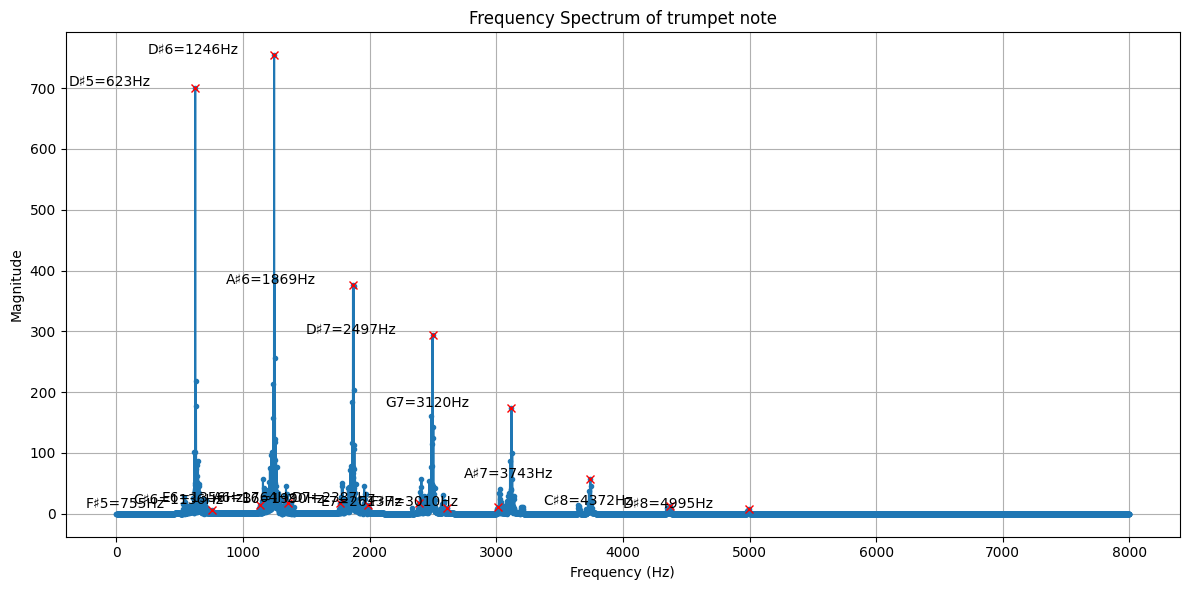

In [38]:
fig, ax, peak_frequencies = plot_frequency_spectrum(summed_signal, sr, return_peaks=True)

In [39]:
586*2

1172

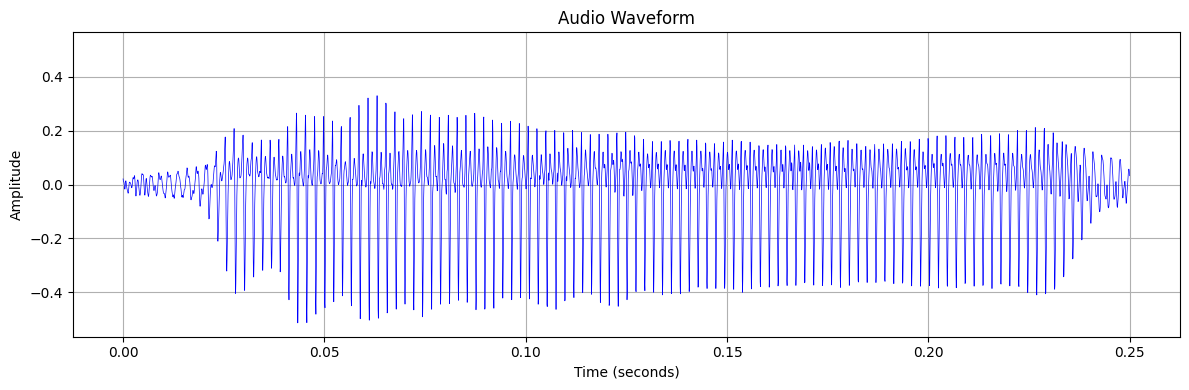

In [40]:
fig, ax = plot_waveform(summed_signals, sr)

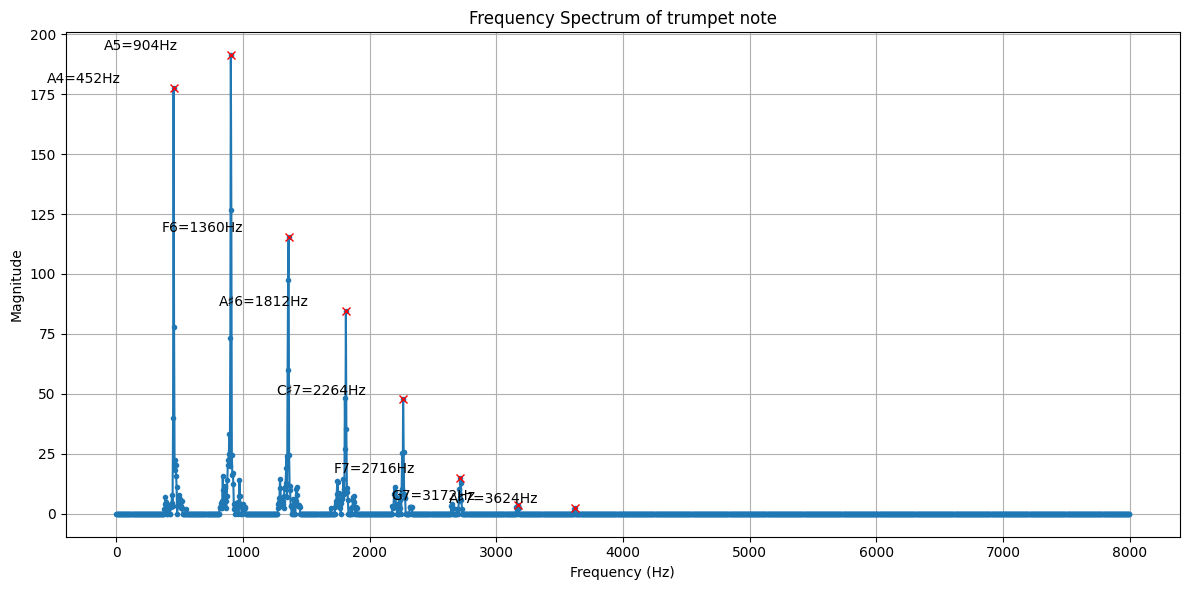

In [41]:
fig, ax = plot_frequency_spectrum(summed_signals, sr)

There are many applications - removing background noise, cleaning up "trumpet tone" in post. 

# Synthetic Trumpet sound

In [42]:
time_seconds = np.linspace(0, 1, 16000)
amplitude = 1
phase = 0
pure_fundamental = reconstruct_frequency(624, time_seconds, amplitude, phase)

In [43]:
get_frequency_phase(pure_fundamental, 16000, 624)

np.float64(0.12252211348982807)

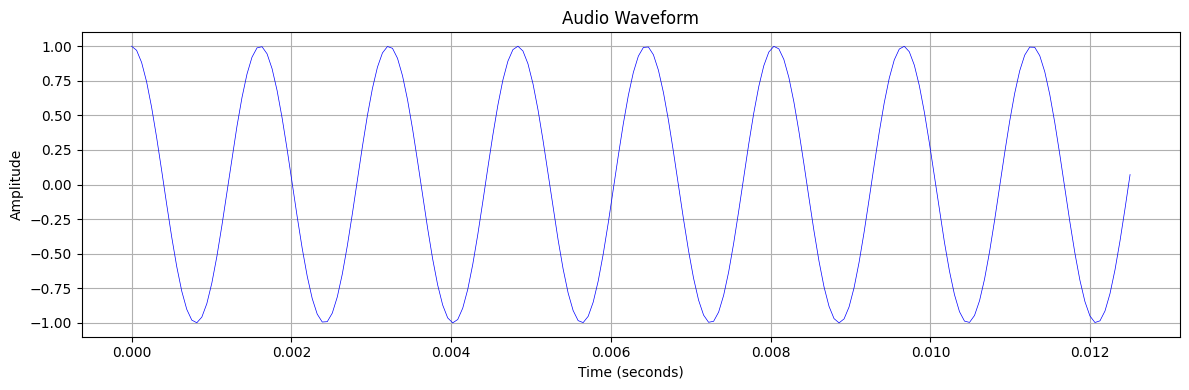

In [44]:
fig, ax = plot_waveform(pure_fundamental[:200], 16000)

In [45]:
ipd.Audio(data=pure_fundamental, rate=16000)

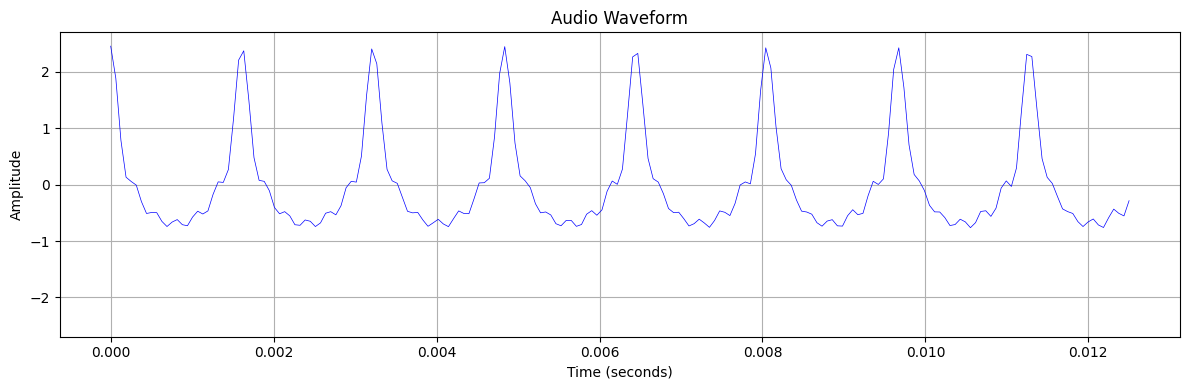

In [46]:
harmonic_series = pure_fundamental + reconstruct_frequency(1247, time_seconds, amplitude/2, phase)\
    + reconstruct_frequency(1871, time_seconds, amplitude/3, phase)\
    + reconstruct_frequency(2495, time_seconds, amplitude/4, phase)\
    + reconstruct_frequency(3119, time_seconds, amplitude/5, phase)\
    + reconstruct_frequency(3749, time_seconds, amplitude/6, phase)\

fig, ax = plot_waveform(harmonic_series[:200], 16000)

In [47]:
amplitude_626 = get_frequency_amplitude(harmonic_series, 16000, 3749)
phase_626 = get_frequency_phase(harmonic_series, 16000, 3749)
amplitude_626, phase_626

(np.float64(0.1519269567189666), np.float64(0.7361144286434858))

In [48]:
amplitude/6, phase

(0.16666666666666666, 0)

In [49]:
ipd.Audio(data=harmonic_series, rate=16000)

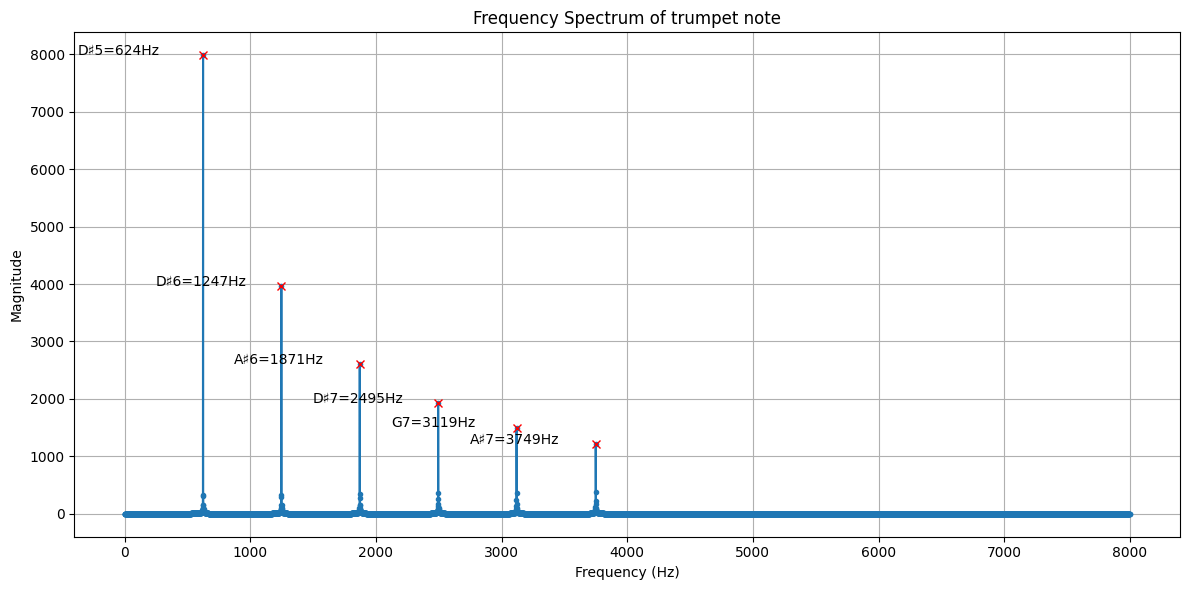

In [50]:
fig, ax = plot_frequency_spectrum(harmonic_series, 16000)

In [51]:
filtered_test = harmonic_series - reconstruct_frequency(3749, time_seconds, amplitude/6, phase)

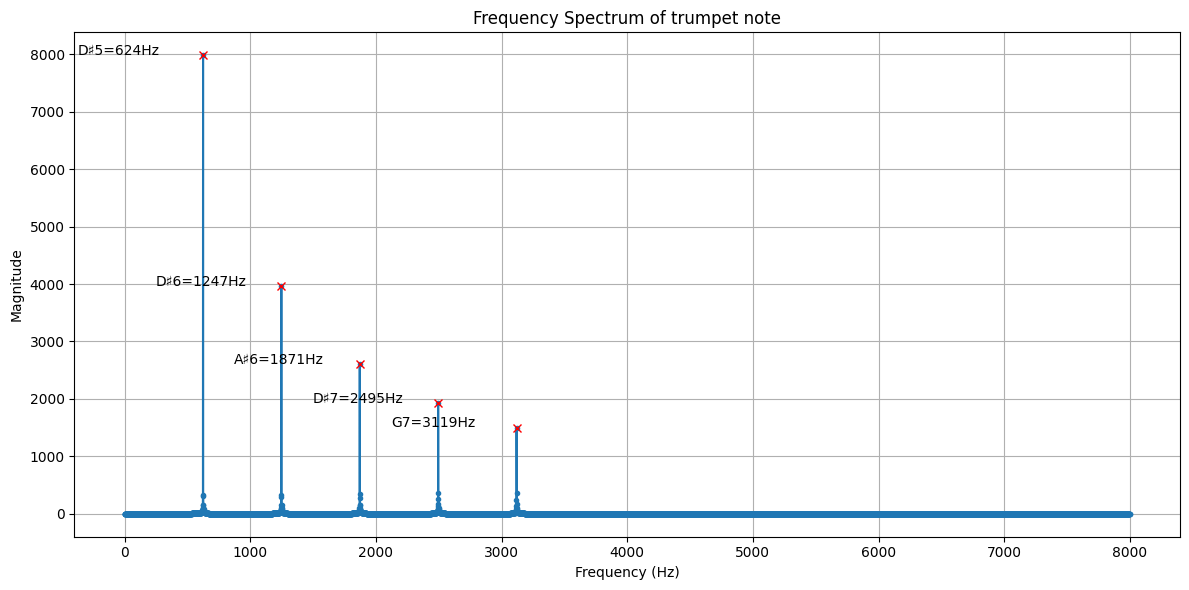

In [52]:
fig, ax = plot_frequency_spectrum(filtered_test, 16000)